The following code is to check adversarial attached on different neural networks. The following tutorials or codes have been very useful during the development: 
    
    https://github.com/PetraVidnerova/rbf_keras
    https://keras.io/layers/writing-your-own-keras-layers/
    https://nextjournal.com/gkoehler/digit-recognition-with-keras
    https://fairyonice.github.io/Generate-adversarial-examples-using-TensorFlow.html
    

In [1]:
import tensorflow as tf

import numpy as np

import pandas as pd

import os

import matplotlib.pyplot as plt 
%matplotlib inline

import gzip
import _pickle as cPickle

import sklearn
from sklearn import datasets
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale


from IPython import display

from keras.models import Sequential, load_model, Model
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Orthogonal, Constant
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.datasets import mnist


import math
import random 
import time


Using TensorFlow backend.


In [2]:
#_____initializer for RBF
class InitCentersKmean(Initializer):
    """ Initializer for initialization of centers of RBF network
        using K-mean.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows 
          are taken as centers)
    """
    def __init__(self, X):
        self.X = X
        print("_____ initializing center using InitCentersKmean _____")

    def __call__(self, shape, dtype=None):
        # "shape" is the input_shape for "self.add_weigh" down below
        self.center = sklearn.cluster.k_means(self.X, init='random', n_clusters=shape[0], max_iter = 1, n_jobs=-1)
        
        return self.center[0]

#______ the custom RBF layer        
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units. 

    # Example
 
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X), 
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    

    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas 

    """
   
    def __init__(self, output_dim, betas, initializer, **kwargs):
        self.output_dim = output_dim # dim of the layer's output, i.e. in this case: number of centers in this layer
        self.init_betas = betas 
        self.initializer = initializer 

        super().__init__(**kwargs) #python3 format

    # input shape is the shape from output of last layers. in this case, it's data: [?, 784]
    def build(self, input_shape): 
        self.centers = self.add_weight(name='centers', 
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,), 
                                     initializer=Constant(value=self.init_betas),
                                     trainable=True)
        
        super().build(input_shape) #python3
     
    def call(self, x):

        C=K.expand_dims(self.centers) # shape (ncenter, 784, 1) for broadcast
        H = K.transpose(C-K.transpose(x)) # K.transpose(x) shape (784, ?), then this shape: 

        """
        # the following printout is used for debugging purpose
        print("self.centers.shape: ", self.centers.shape)
        print("x.shape", x.shape)
        print("K.transpose(x).shape: ", K.transpose(x).shape)
        print("C.shape: ", C.shape)
        print("H.shape: ", H.shape)
        print("self.betas.shape: ", self.betas.shape)
        print("K.sum(H**2, axis=-2).shape: ", K.sum(H**2, axis=-2).shape)
        print("call return shape: ", K.exp( -self.betas * K.sum(H**2, axis=-2)).shape)
        """
        a = K.exp( -K.sum(H**2, axis=-2)/(2*self.betas*self.betas))
        
        return a
             

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        #base_config = super(RBFLayer, self).get_config()
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
#___ load and normalize mnist data 
def load_mnist_data(n_classes):

    (X_train_raw, Y_train_raw), (X_test_raw, Y_test_raw) = mnist.load_data()
    
    #plt.imshow(X_train_raw[0])
    # Normalizing the input data to max=1 helps to speed up the training. 
    # reshape each image to 1D vector for simplicity
    n_train = X_train_raw.shape[0]
    n_test = X_test_raw.shape[0]
    v_len = X_train_raw.shape[1]*X_train_raw.shape[2]    
    
    X_train = X_train_raw.reshape(n_train, v_len)
    X_test = X_test_raw.reshape(n_test, v_len)
    
    # normalizing the data to help with the training. accurancy is lower than sklearn.preprocessing.scale
    """
    max_pixel = np.max(X_train)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= max_pixel
    X_test /= max_pixel
    """
    #using sklearn.preprocessing.scale, leads to higher accuracy than normalization by max as above
    X_train = scale(X_train)
    X_test = scale(X_test)

    
    #Do it only when the final layers output is, e.g. 10
    # one-hot encoding using keras' numpy-related utilities
    Y_train = np_utils.to_categorical(Y_train_raw, n_classes)
    Y_test = np_utils.to_categorical(Y_test_raw, n_classes)
    
    return X_train_raw, Y_train_raw, X_test_raw, Y_test_raw, X_train, Y_train, X_test, Y_test

In [4]:
#__ Neural network model
class NN_model():
    def __init__(self, name, X, n_classes, n_center, beta, initializer):
                
        self.model = Sequential()
                    
        if name == "RBF":
            print("++++ using RBF network +++++")
            one_sample_shape = X.shape[-1] # shape for each individual sample

            self.rbflayer = RBFLayer(n_center, beta, 
                                    initializer=initializer(X),
                                    # input_shape is the data shape. The 2nd dim of (one_sample_shape, ) is the number of samples and is treated as ? in keras
                                    input_shape=(one_sample_shape, ), name=name) 

            self.model.add(self.rbflayer)
            self.model.add(Dense(n_classes, name='logits'))
            self.model.add(Activation('softmax'))
        elif name=="dense_1L": 
            print("++++ using 1-hidden layer w/10 neutons dense network +++++")
            self.model.add(Dense(10, input_shape=(784,), name=name))
            self.model.add(Activation('relu'))                            
            #self.model.add(Dropout(0.2))
            self.model.add(Dense(n_classes, name='logits'))
            self.model.add(Activation('softmax'))
        elif name=="dense": 
            print("++++ using 2-hidden layer w/512 neurons dense network +++++")
            self.model.add(Dense(512, input_shape=(784,), name=name))
            self.model.add(Activation('relu'))                            
            self.model.add(Dropout(0.2))

            self.model.add(Dense(512))
            self.model.add(Activation('relu'))
            self.model.add(Dropout(0.2))

            self.model.add(Dense(n_classes, name='logits'))
            self.model.add(Activation('softmax'))
        else:
            print("+++++ only option: RBF or dense_1L or dense ++++")
            exit()
                             # file and directory for storing weight
        self.weight_dir = 'model_parameter/'
        self.weight_file = self.weight_dir+name+'_weights.h5'
        if not os.path.isdir(self.weight_dir):
            os.mkdir(self.weight_dir)
    
        self.model.summary()
        self.model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
   
    def outputs(self):
        return self.model.outputs
    
    def inputs(self):
        return self.model.inputs


In [5]:
#__ daughter class of NN_model, focus on functionality
class NN_mnist(NN_model):
    def __init__ (self, name, n_classes, X, Y, X_raw, Y_raw, X_val, Y_val, n_center = 10, initializer=InitCentersKmean, beta=10):
        self.X_raw = X_raw  # input original data 
        self.Y_raw = Y_raw  # input original label         
        self.X = X  # input  data after normalization for mean and variance 
        self.Y = Y  # input label after one_hot conversion
        self.X_val = X_val # validation data during the model.fit
        self.Y_val = Y_val # validation label during model.fit
                
        super().__init__(name, X, n_classes, n_center, beta, initializer) # initialize parents class
    
    # everything else is the same except the objects included in this function, in this case, self.X, self.X_raw, self.Y_raw
    def __call__(self, X):
        if(X.ndim != X_train.ndim):  # the input shape is (nsample, singe_image.shape). 
                                       # If a single image is the input, it need to expand to the "nsample" dimension
            print("++single image: expanding dimentions to add nsample dim +++")
            X = np.expand_dims(X, axis=0)
        self.X = X
        
        return self.get_logits(), self.get_probs()
    
    # plot the loss and accuracy of the training as a function of epoch
    def plot_training_history(self):
        fig = plt.figure()
        plt.subplot(2,1,1)
        plt.plot(self.history.history['acc'])
        plt.plot(self.history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

        plt.subplot(2,1,2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        plt.tight_layout()

    
    # plot images samples
    def plot(self, indices, n_sample, figsize):
        fig, axes = plt.subplots(3,n_sample,figsize=figsize, subplot_kw={'xticks':[], 'yticks':[]}) #subplot_kw option removes ticks in X, Y axes

        for i in range(n_sample):
            index=indices[i]
            #  the original image before the normalization (this should be used for adversarial attacks)
            axes[0, i].imshow(self.X_raw[index], cmap='gray', interpolation='none')
            axes[0, i].set_title("True: {}  predict: {}".format(self.Y_raw[index], self.predicted_classes[index]))

            # normalized image. The background become uneven due to the normalization. Looks like already has ADATK
            a = self.X[index].reshape(28, 28)
            axes[1, i].imshow(a, cmap='gray', interpolation='none')

            # 1-D histogram of normalized image
            axes[2, i].hist(self.X[index], bins=20)
            
        fig.tight_layout()
        fig.subplots_adjust(hspace=0.01)
    

    # plot image samples include original, normalized. Need to be updated to included ada image later.
    def plot_random_sample(self, X, X_raw, Y_raw, which_to_plot, n_sample = 8, figsize=(15,5)):   
        self.X = X
        self.X_raw = X_raw
        self.Y_raw = Y_raw
        
        # identify the indices of correctly and incorrectly recognized images
        self.identify_correct_incorrect_prediction()
        
        if which_to_plot == "correct":
            print("__correctly identified image _____")
            indices = np.random.choice(self.correct_indices, size=n_sample) # random indices of correctly identifed images 
        elif which_to_plot == "incorrect":
            print("__wrongly identified image _____")
            indices = np.random.choice(self.incorrect_indices, size=n_sample) # random indices of incorrectly identified images in the data
        else:
            print("___ try again on inputs: correct or incorrect ___")

        self.plot(indices, n_sample, figsize)
        
    # evulated the model
    def eval(self):
        loss_and_metrics = self.model.evaluate(self.X, self.Y, verbose=2) # the metric is defined when compiling the model
        print("__Loss:  ", loss_and_metrics[0])
        print("__Accuracy: ", loss_and_metrics[1])
        
    # identify correct or incorrect prediction indices which is used for plotting later
    def identify_correct_incorrect_prediction(self): 
        print("___ calculating the correct and incorrect prediction _____")
        self.predicted_classes = np.argmax(self.model.predict(self.X), axis=-1)
        self.correct_indices = np.nonzero(self.predicted_classes == self.Y_raw)[0]
        self.incorrect_indices = np.nonzero(self.predicted_classes != self.Y_raw)[0]
        print("__complete___")
        
            # run the model, save the weight and plot the training history
    def run(self, batch_size=100, epochs=1, verbose=2):
        self.history = self.model.fit(self.X, self.Y,
                                      batch_size,
                                      epochs,
                                      verbose,
                                      validation_data=(self.X_val, self.Y_val))
        # saving the model
        """
        # loading model has problem this way. it complain RBF layer is not unknow. 
        save_dir = "./results/"
        model_name = 'RBF.h5'
        model_path = os.path.join(save_dir, model_name)
        model.save(model_path)
        print('Saved trained model at %s ' % model_path)
        """
        print("___ saving the model weight____")    
        self.model.save_weights(self.weight_file)
                
        # plot the history of the training 
        self.plot_training_history()
        
    # load the model weight. Currently the can not save the entire model since it compile RBFlayer is not defined
    def load_model(self): 
        if os.path.exists(self.weight_file):
            self.model.load_weights(self.weight_file)
        else:
            print("++++ no model weight file: ", self.weight_file, "can be found ++++")
            exit()


    # get output from a layers. In this case, for logits
    def get_logits(self):

        self.logits_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('logits').output)
  
        return self.logits_layer_model.predict(self.X)
    
    # get the probability of each class
    def get_probs(self):
        return self.model.predict(self.X)


In [6]:
n_classes = 10
n_center = 10
beta = 10

#model_name = "dense_1L"
model_name = "RBF"
#model_name = "dense"


X_train_raw, Y_train_raw, X_test_raw, Y_test_raw, X_train, Y_train, X_test, Y_test = load_mnist_data(n_classes)

model = NN_mnist(model_name, n_classes,  X_train, Y_train, X_train_raw, Y_train_raw, X_test, Y_test, n_center, InitCentersKmean, beta)


C:\Users\wxie\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


++++ using RBF network +++++
_____ initializing center using InitCentersKmean _____
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RBF (RBFLayer)               (None, 10)                7850      
_________________________________________________________________
logits (Dense)               (None, 10)                110       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 19s 319us/step - loss: 2.2181 - acc: 0.1787 - val_loss: 2.1036 - val_acc: 0.3023
___ saving the model weight____
__Loss:   2.1091973428726196
__Accuracy:  0.3006


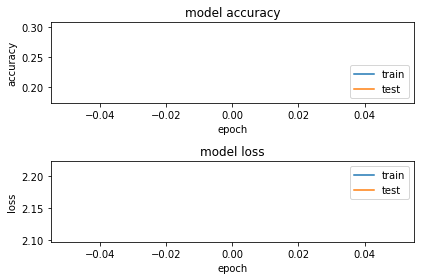

In [7]:
batch_size=100 
epochs=1
verbose=1
is_training = "yes"

if is_training:
    model.run(batch_size, epochs, verbose)
else:
    model.load_model()

model.eval()

___ calculating the correct and incorrect prediction _____
__complete___
__wrongly identified image _____


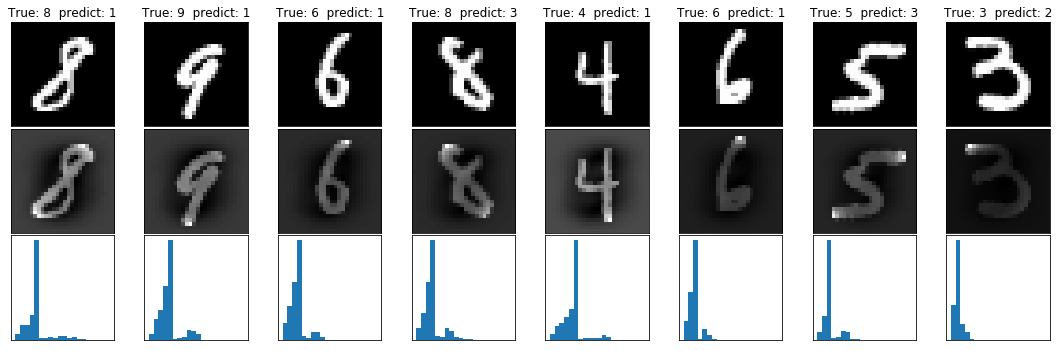

In [8]:
# this is the training sample
model.plot_random_sample(X_train, X_train_raw, Y_train_raw, "incorrect")

___ calculating the correct and incorrect prediction _____
__complete___
__correctly identified image _____


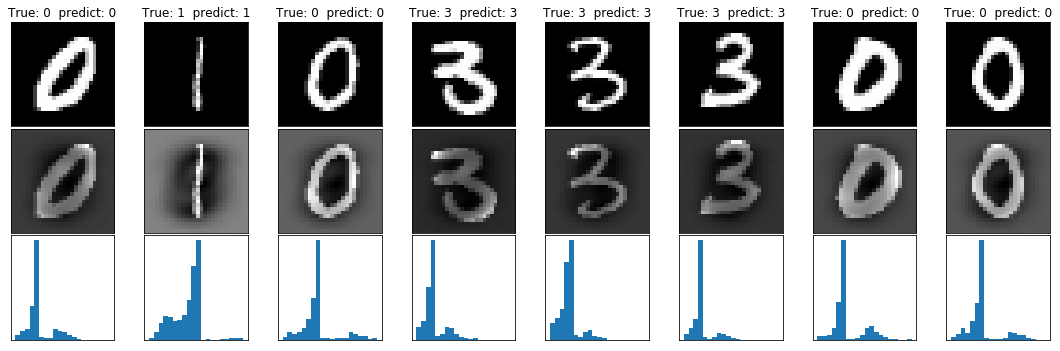

In [9]:
# this is the test sample 
model.plot_random_sample(X_test, X_test_raw, Y_test_raw, "correct")

In [10]:
X = np.expand_dims(X_train[0], 0)
_, prob = model(X)
print(np.argmax(prob))

2


In [11]:
# Write the graph in binary .pb file
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

outdir = "keras_to_TF"
try:
    os.mkdir(outdir )
except:
    pass


prefix = model_name 
name = 'output_graph.pb'
# Alias the outputs in the model - this sometimes makes them easier to access in TF
pred = []
pred_node_names = []
for i, o in enumerate(model.outputs()):
        pred_node_names.append(prefix+'_'+str(i))
        pred.append(tf.identity(o, name=pred_node_names[i]))
print('Output nodes names are: ', pred_node_names[0])


sess = K.get_session()
    
# Write the graph in human readable
# f = 'graph_def_for_reference.pb.ascii'
# tf.train.write_graph(sess.graph.as_graph_def(), outdir, f, as_text=True)
# print('Saved the graph definition in ascii format at: ',  os.path.join(outdir, f))

constant_graph = graph_util.convert_variables_to_constants(sess, 
                                                           sess.graph.as_graph_def(), 
                                                           pred_node_names)
graph_io.write_graph(constant_graph, outdir, name, as_text=False)
## Finally delete the Keras's session
#K.clear_session()

Output nodes names are:  RBF_0
INFO:tensorflow:Froze 4 variables.
Converted 4 variables to const ops.


'keras_to_TF\\output_graph.pb'

In [12]:
tf.reset_default_graph()

def load_graph(model_name):
    #graph = tf.Graph()
    graph = tf.get_default_graph()
    graph_def = tf.GraphDef()
    with open(model_name, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)
    return graph

my_graph = load_graph(model_name=os.path.join(outdir, name))


In [14]:
# print out the operation name for double check ...
for i, op in enumerate(tf.get_default_graph().get_operations()):
    print ("{: 3.0f}: {}".format(i,op.name))


  0: import/logits/bias
  1: import/logits/bias/read
  2: import/logits/kernel
  3: import/logits/kernel/read
  4: import/RBF/mul/x
  5: import/RBF/Sum/reduction_indices
  6: import/RBF/pow/y
  7: import/RBF/transpose_1/Range/delta
  8: import/RBF/transpose_1/Range/start
  9: import/RBF/transpose_1/sub/y
 10: import/RBF/transpose/Range/delta
 11: import/RBF/transpose/Range/start
 12: import/RBF/transpose/sub/y
 13: import/RBF/ExpandDims/dim
 14: import/RBF/betas
 15: import/RBF/betas/read
 16: import/RBF/mul
 17: import/RBF/mul_1
 18: import/RBF/centers
 19: import/RBF/centers/read
 20: import/RBF/ExpandDims
 21: import/RBF_input
 22: import/RBF/transpose/Rank
 23: import/RBF/transpose/Range
 24: import/RBF/transpose/sub
 25: import/RBF/transpose/sub_1
 26: import/RBF/transpose
 27: import/RBF/sub
 28: import/RBF/transpose_1/Rank
 29: import/RBF/transpose_1/Range
 30: import/RBF/transpose_1/sub
 31: import/RBF/transpose_1/sub_1
 32: import/RBF/transpose_1
 33: import/RBF/pow
 34: impor

In [15]:
input_op = my_graph.get_operation_by_name("import/"+model_name+"_input") # name of input operation 
output_op = my_graph.get_operation_by_name("import/"+pred_node_names[0]) # name of output operation
logit_op = my_graph.get_operation_by_name("import/logits/BiasAdd") # name of logits operation. Double checked from keras model output

ops = (input_op,output_op, logit_op)

print(input_op.outputs[0].shape)
print(output_op.outputs[0].shape)

(?, 784)
(?, 10)


In [16]:
class AdversarialImage(object):
    def __init__(self, inp, out, logits, eps=0.01):
        '''
        inp : input tensor  (image)
        out : output tensor (y_pred)
        eps : scalar
        '''
        self.inp = inp.outputs[0] # input tensor
        self.out = out.outputs[0] # output tensor
        self.logits = logits.outputs[0] # logits tensor
                   
    def mse_tf(self,y_pred,y_test, verbose=True):
        '''
        y_pred : tensor 
        y_test : tensor having the same shape as y_pred
        '''
        ## element wise square
        square = tf.square(tf.subtract(y_pred ,y_test))## preserve the same shape as y_pred.shape
        ## mean across the final dimensions
        ms = tf.reduce_mean(square)

        return(ms)

    def get_adv_image(self, image, goal, nsteps, eps=0.01, verbose=0):

        #sess = tf.InteractiveSession()
        #sess.run(tf.global_variables_initializer())

        y_goal_tf = tf.expand_dims(tf.one_hot(goal, 10), axis=0)
        y_pred_tf = self.logits 

        loss = self.mse_tf(y_pred_tf,y_goal_tf)

        grad_tf  = tf.gradients(loss, self.inp)[0]

        adv_image = self.inp - eps*grad_tf        
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            # gradient descent
            for i in range(nsteps):
                # need to update image everytime
                adv, vloss, lg, grad, = sess.run([adv_image, loss, y_pred_tf,  grad_tf ], feed_dict={self.inp: image})
                image = adv
                if verbose != 0:
                    print("loss: ", vloss)
                    print("grad: ", grad[0][0:10])
                    print("logitis:", lg)

                if(i%1000 == 0):
                    print("loss: ", vloss)
                 
        return adv
    
    def predict(self,X):

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            y_pred, logits = sess.run([self.out, self.logits], feed_dict={self.inp:X})
            
        return y_pred, logits


In [17]:
test = AdversarialImage(*ops)

[[0.15367803 0.10517132 0.0902349  0.10823563 0.08901767 0.10340784
  0.07989714 0.08908422 0.09780236 0.08347096]]
0


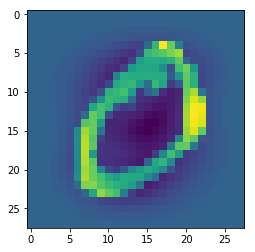

In [18]:
X = np.expand_dims(X_train[1], 0)

prob, logits = test.predict(X)
print(prob)
print(np.argmax(prob))
plt.imshow(X.reshape(28, 28))

In [31]:
a = test.get_adv_image(X, 4, 20000, 4)

loss:  0.19752179
loss:  0.11856657
loss:  0.11300836
loss:  0.10942175
loss:  0.1075081
loss:  0.10624881
loss:  0.105284795
loss:  0.10446499
loss:  0.10371743
loss:  0.10301272
loss:  0.102351405
loss:  0.10175152
loss:  0.10123028
loss:  0.1007912
loss:  0.100425765
loss:  0.10012162
loss:  0.09986714
loss:  0.09965317
loss:  0.09947251
loss:  0.09931937


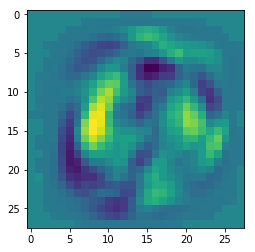

In [32]:
plt.imshow(a.reshape(28, 28))

In [33]:
c, d = test.predict(a)
print(c)

[[0.10966112 0.09218243 0.09337789 0.09786154 0.1137324  0.08849058
  0.10708936 0.10195377 0.09839106 0.09725983]]


In [34]:
print(np.argmax(c))

4
